# Mobile Price Prediction

I would like to analyze and create a predictive model for predicting the price range of mobile phones using a dataset that describes the features of mobile phones. Each row in the dataset represents the specifications of a mobile phone and the target feature is an ordinal variable representing the price range. This dataset has the following descriptive features. 

- battery_power: Battery power in mAh
- blue: Has bluetooth or not
- clock_speed: Processor clock speed
- dual_sim: Has dual sim support or not
- fc: Front Camera mega pixels
- four_g: Has 4G or not
- int_memory: Internal Memory in Gigabytes
- m_dep: Depth of the phone in cm
- mobile_wt: Weight of the phone
- n_cores: Number of cores of processor
- pc: Primary Camera mega pixels
- px_height: Pixel Resolution Height
- px_width: Pixel Resolution Width
- ram: RAM in Megabytes
- sc_h: Screen height in cm
- sc_w: Screen Width in cm
- talk_time: Longest talk time in hours
- three_g: Has 3G or not
- touch_screen: Has touchscreen or not
- wifi: Has WiFi or not

In [1]:
#import utility libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

target_feature = 'price_range'
df = pd.read_csv("https://raw.githubusercontent.com/JordanVencel/MobilePricePrediction/main/mppp_data.csv")

## Identifing Outliers Using the IQR Method and Replace Outliers Using the Clamping Technique
I will first identify the continuous features (interval and ratio scale), then identify outliers for these features using the interquartile range (IQR) method. The IQR, a measure of statistical dispersion, is the range between third and first quartile ($IQR = Q3-Q1$) and upper and lower bounds for the outliers can be set as:
 - $lower = Q1 - 1.5IQR$
 - $upper = Q3 + 1.5IQR$

I will apply this clamp transformation only to the continious descriptive features and not to the categorical ones.

In [2]:
# manually identify the categorical and continuous features, and put the column names in the lists below 
cont_features = ['battery_power','clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
cat_features = ['blue','dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'price_range']
all_features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']

cl_df = df.copy()

In [3]:
# Get upper and lower thresholds for each continuous feature for clamping transformation
clamping_ranges = []
cont_df = cl_df[cont_features]

for column in cont_df.iteritems():
    iqr = column[1].describe()[6] - column[1].describe()[4]
    lower = column[1].describe()[4] - (1.5 * iqr)
    upper = column[1].describe()[6] + (1.5 * iqr)
    iqr_range = []
    iqr_range.append(lower)
    iqr_range.append(upper)
    clamping_ranges.append(iqr_range)


In [4]:
# Apply clamp transformation
for column in cont_df.iteritems():
    column_index = cont_features.index(column[0])
    row_index = 0
    for value in column[1]:
        if (value < clamping_ranges[column_index][0]):
            value = clamping_ranges[column_index][0]
            cont_df.at[row_index, column_index] = value
            row_index += 1
        elif (value > clamping_ranges[column_index][1]):
            value = clamping_ranges[column_index][1]
            cont_df.at[row_index, column_index] = value
            row_index += 1

# Re-copy clamped values back into cleaned dataframe 
for feature in cont_features:
    cl_df[feature] = cont_df[feature]

## Normalizing the Data Using Range Normalization
I will now use sklearn's range normalization procedure (i.e., `MinMaxScaler`), initialize a scaler and normalize the features to a [0,1] range.

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(cl_df[all_features])
transformed_array = scaler.transform(cl_df[all_features])
transformed_array[1]

array([0.34736139, 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.82258065, 0.66666667, 0.46666667, 0.28571429,
       0.3       , 0.46173469, 0.99332443, 0.63468733, 0.85714286,
       0.16666667, 0.27777778, 1.        , 1.        , 0.        ])

In [6]:
normalized_df = cl_df.copy()
feature_index = 0

for row in normalized_df.iterrows():
    row_index = row[0]
    column_index = 0
    for value in transformed_array[feature_index]:
        column_name = all_features[column_index]
        normalized_df.at[row_index, column_name] = value
        column_index += 1
    feature_index += 1

normalized_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,0.227789,0,0.68,0,0.052632,0,0.080645,0.555556,0.900000,0.142857,...,0.010204,0.170895,0.612774,0.285714,0.388889,0.944444,0,0,1,1
1,0.347361,1,0.00,1,0.000000,1,0.822581,0.666667,0.466667,0.285714,...,0.461735,0.993324,0.634687,0.857143,0.166667,0.277778,1,1,0,2
2,0.041416,1,0.00,1,0.105263,1,0.629032,0.888889,0.541667,0.571429,...,0.644388,0.811749,0.627205,0.428571,0.111111,0.388889,1,1,0,2
3,0.076152,1,0.80,0,0.000000,0,0.129032,0.777778,0.425000,0.714286,...,0.620408,0.858478,0.671566,0.785714,0.444444,0.500000,1,0,0,2
4,0.881764,1,0.28,0,0.684211,1,0.677419,0.555556,0.508333,0.142857,...,0.616327,0.475300,0.308658,0.214286,0.111111,0.722222,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.195725,1,0.00,1,0.000000,1,0.000000,0.777778,0.216667,0.714286,...,0.623469,0.927904,0.110102,0.571429,0.222222,0.944444,1,1,0,0
1996,0.977956,1,0.84,1,0.000000,0,0.596774,0.111111,0.891667,0.428571,...,0.466837,0.977971,0.474613,0.428571,0.555556,0.777778,1,1,1,2
1997,0.941884,0,0.16,1,0.052632,1,0.548387,0.666667,0.233333,1.000000,...,0.442857,0.755674,0.748530,0.285714,0.055556,0.166667,1,1,0,3
1998,0.675351,0,0.16,0,0.210526,1,0.709677,0.000000,0.541667,0.571429,...,0.171429,0.113485,0.163816,0.928571,0.555556,0.944444,1,1,1,0


## Create a Nearest Neighbor classifier for classification
Using sklearn's k-nearest neighbors classifier (`KNeighborsClassifier`), I will initialize a similarity-based classification model. The number of nearest neighbors (`n_neighbors`) parameter is set to 1. 

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = 1)
x_train,x_test,y_train,y_test = train_test_split(normalized_df[all_features], normalized_df['price_range'], test_size=0.33, random_state=53)

In [8]:
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

In [9]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.396969696969697

## Searching For the Best $k$ 
Now I'll find the training and testing accuracy for different $k$ values ( for each $k$ where $2 \geq k \geq 150$. ) 

In [10]:
max_k = 150
k_list = []
for k in range(2, max_k + 1):
    k_list.append(k)
k_df = pd.DataFrame({'k': k_list})

training_accuracy_list = []
testing_accuracy_list = []

for k in range(2, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    # Training accuracy
    train_pred = knn.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    training_accuracy_list.append(train_accuracy)
    # Testing accuracy
    test_pred = knn.predict(x_test)
    testing_accuracy = accuracy_score(y_test, test_pred)
    testing_accuracy_list.append(testing_accuracy)
accuracy_df = pd.DataFrame({'training_accuracy': training_accuracy_list, 'testing_accuracy': testing_accuracy_list})

plot_df = pd.DataFrame({'k': k_df['k'], 'training_accuracy': accuracy_df['training_accuracy'], 'testing_accuracy': accuracy_df['testing_accuracy']})
plot_df

,k,training_accuracy,testing_accuracy
0,2,0.672388,0.377273
1,3,0.638806,0.372727
2,4,0.632090,0.386364
3,5,0.607463,0.392424
4,6,0.596269,0.409091
...,...,...,...
144,146,0.587313,0.583333
145,147,0.583582,0.578788
146,148,0.594776,0.586364
147,149,0.594030,0.581818


<AxesSubplot:xlabel='k', ylabel='value'>

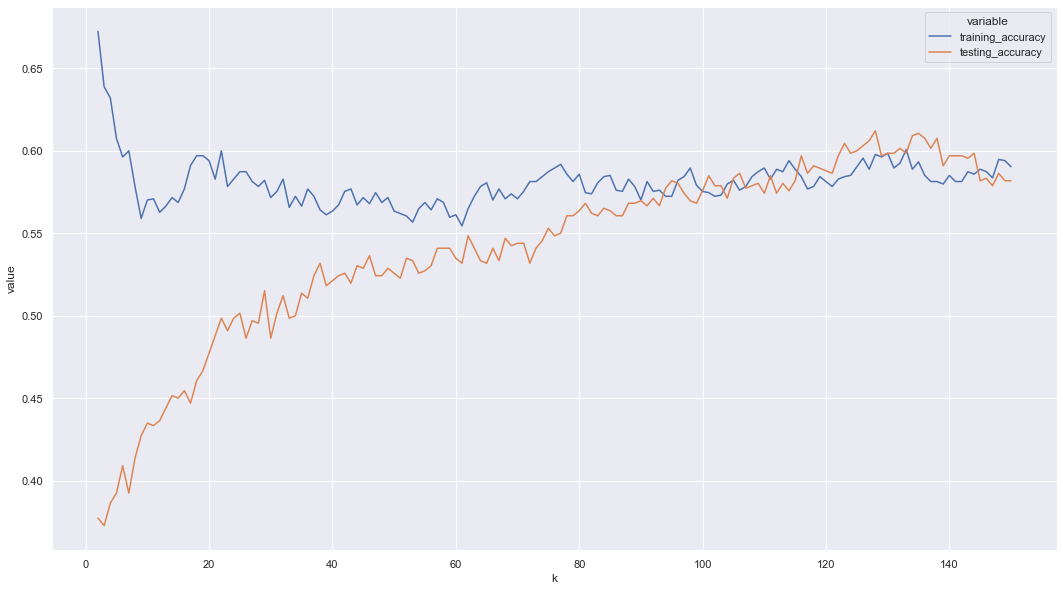

In [11]:
import seaborn as sb 
sb.set(rc={'figure.figsize':(18,10)})
sb.lineplot(x='k', y='value', hue='variable', data=pd.melt(plot_df, ['k']))

## Impact of Minkowski Orders on kNN Classifiers

Now, let us repeat the same experiment as we did in the last code cell (i.e., find how changing $k$ impact the accuracy), except in combination with Minkowski order parameter (`p`). In other words, I will use the generalized Minkowski distance instead of the default Euclidean distance (where $p = 2$), which can be calculated as

$Minkowski(q, ins, p) = (\sum( |q_j-ins_j|^p ))^{\frac{1}{p}}$

<AxesSubplot:xlabel='k', ylabel='value'>

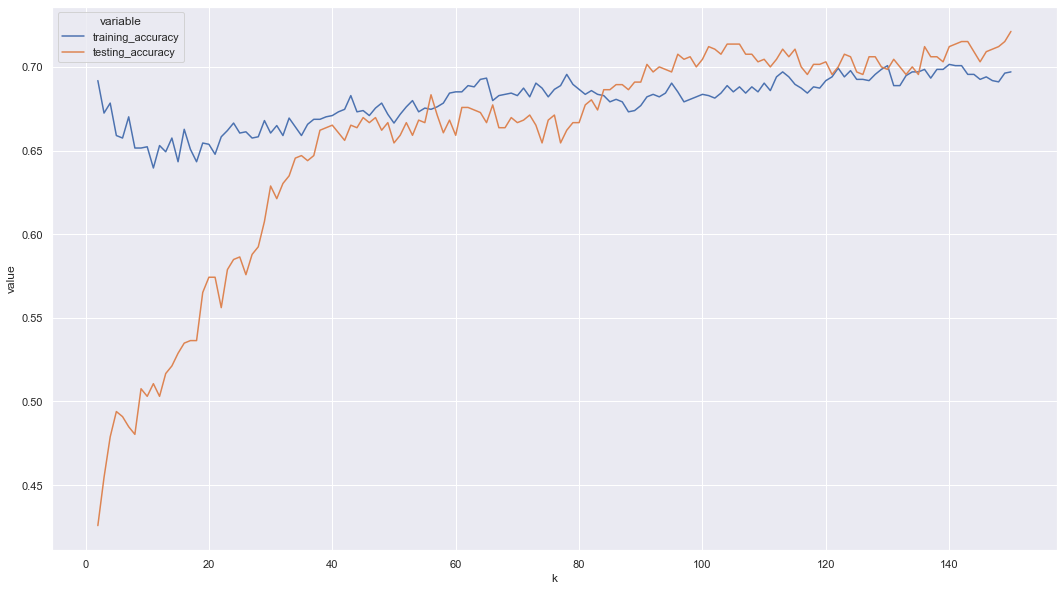

In [12]:
k_list = []
for k in range(2, max_k + 1):
    k_list.append(k)
k_df = pd.DataFrame({'k': k_list})

training_accuracy_list = []
testing_accuracy_list = []

for k in range(2, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors = k, p=1)
    knn.fit(x_train, y_train)
    # Training accuracy
    train_pred = knn.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    training_accuracy_list.append(train_accuracy)
    # Testing accuracy
    test_pred = knn.predict(x_test)
    testing_accuracy = accuracy_score(y_test, test_pred)
    testing_accuracy_list.append(testing_accuracy)
accuracy_df = pd.DataFrame({'training_accuracy': training_accuracy_list, 'testing_accuracy': testing_accuracy_list})

plot_df = pd.DataFrame({'k': k_df['k'], 'training_accuracy': accuracy_df['training_accuracy'], 'testing_accuracy': accuracy_df['testing_accuracy']})
sb.lineplot(x='k', y='value', hue='variable', data=pd.melt(plot_df, ['k']))

<AxesSubplot:xlabel='k', ylabel='value'>

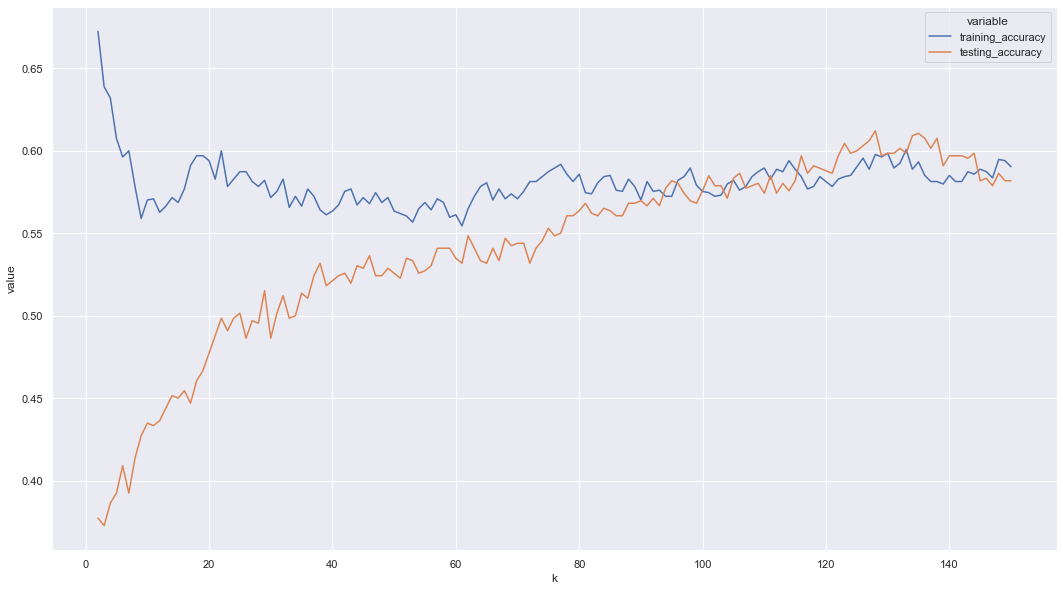

In [13]:
k_list = []
for k in range(2, max_k + 1):
    k_list.append(k)
k_df = pd.DataFrame({'k': k_list})

training_accuracy_list = []
testing_accuracy_list = []

for k in range(2, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors = k, p=2)
    knn.fit(x_train, y_train)
    # Training accuracy
    train_pred = knn.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    training_accuracy_list.append(train_accuracy)
    # Testing accuracy
    test_pred = knn.predict(x_test)
    testing_accuracy = accuracy_score(y_test, test_pred)
    testing_accuracy_list.append(testing_accuracy)
accuracy_df = pd.DataFrame({'training_accuracy': training_accuracy_list, 'testing_accuracy': testing_accuracy_list})

plot_df = pd.DataFrame({'k': k_df['k'], 'training_accuracy': accuracy_df['training_accuracy'], 'testing_accuracy': accuracy_df['testing_accuracy']})
sb.lineplot(x='k', y='value', hue='variable', data=pd.melt(plot_df, ['k']))

<AxesSubplot:xlabel='k', ylabel='value'>

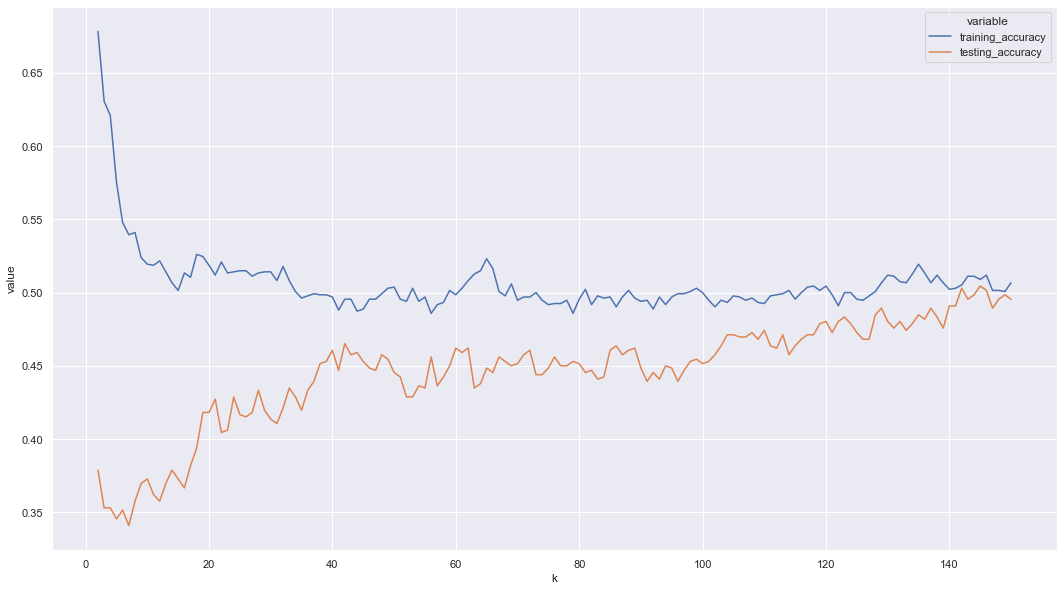

In [14]:
k_list = []
for k in range(2, max_k + 1):
    k_list.append(k)
k_df = pd.DataFrame({'k': k_list})

training_accuracy_list = []
testing_accuracy_list = []

for k in range(2, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors = k, p=3)
    knn.fit(x_train, y_train)
    # Training accuracy
    train_pred = knn.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    training_accuracy_list.append(train_accuracy)
    # Testing accuracy
    test_pred = knn.predict(x_test)
    testing_accuracy = accuracy_score(y_test, test_pred)
    testing_accuracy_list.append(testing_accuracy)
accuracy_df = pd.DataFrame({'training_accuracy': training_accuracy_list, 'testing_accuracy': testing_accuracy_list})

plot_df = pd.DataFrame({'k': k_df['k'], 'training_accuracy': accuracy_df['training_accuracy'], 'testing_accuracy': accuracy_df['testing_accuracy']})
sb.lineplot(x='k', y='value', hue='variable', data=pd.melt(plot_df, ['k']))

<AxesSubplot:xlabel='k', ylabel='value'>

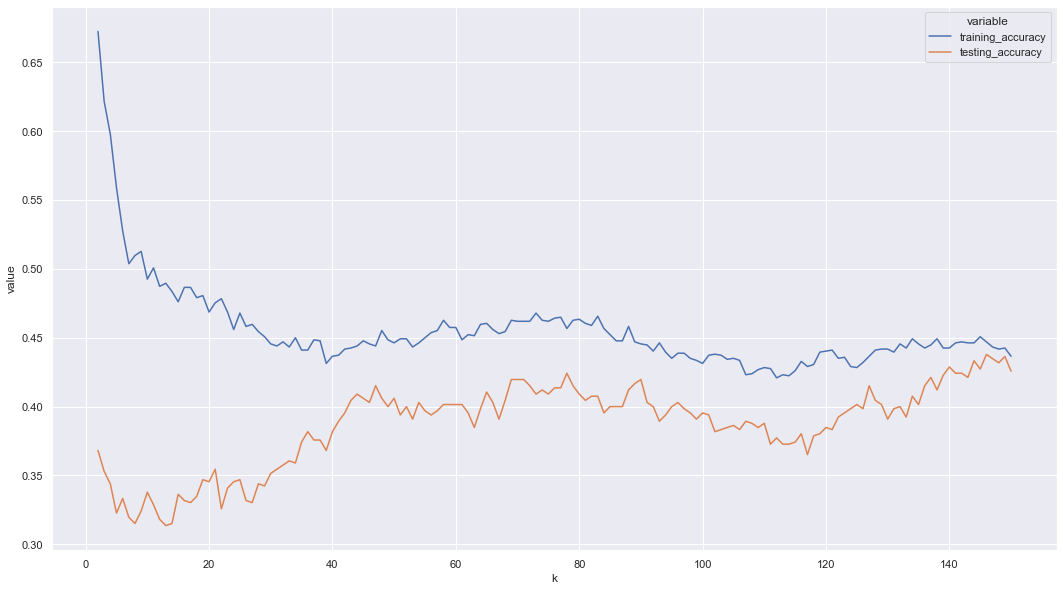

In [15]:
k_list = []
for k in range(2, max_k + 1):
    k_list.append(k)
k_df = pd.DataFrame({'k': k_list})

training_accuracy_list = []
testing_accuracy_list = []

for k in range(2, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors = k, p=4)
    knn.fit(x_train, y_train)
    # Training accuracy
    train_pred = knn.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    training_accuracy_list.append(train_accuracy)
    # Testing accuracy
    test_pred = knn.predict(x_test)
    testing_accuracy = accuracy_score(y_test, test_pred)
    testing_accuracy_list.append(testing_accuracy)
accuracy_df = pd.DataFrame({'training_accuracy': training_accuracy_list, 'testing_accuracy': testing_accuracy_list})

plot_df = pd.DataFrame({'k': k_df['k'], 'training_accuracy': accuracy_df['training_accuracy'], 'testing_accuracy': accuracy_df['testing_accuracy']})
sb.lineplot(x='k', y='value', hue='variable', data=pd.melt(plot_df, ['k']))

P = 1 is very clearly the optimal Minkowski order value

## Using a Probability-based Classifier

We will now utilize probability-based Naive Bayes classifiers to perform mobile phone price range prediction. The same dataset partitions (with the same training/testing sampling ratio and random seed from Q3) will be used to compare the models. 

We will start with discretizing the continuous features. For each continuous feature in the given dataset, I will create an ordinal variable using equi-frequency binning that will take the integer values (3 [->high], 2 [->medium], 1 [->low]).

After applying discretization on continuous features, I will build a Naive Bayes classifier. In this case, I will use the Categorical Naive Bayes classifier (`CategoricalNB` from `sklearn.naive_bayes` module). 

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


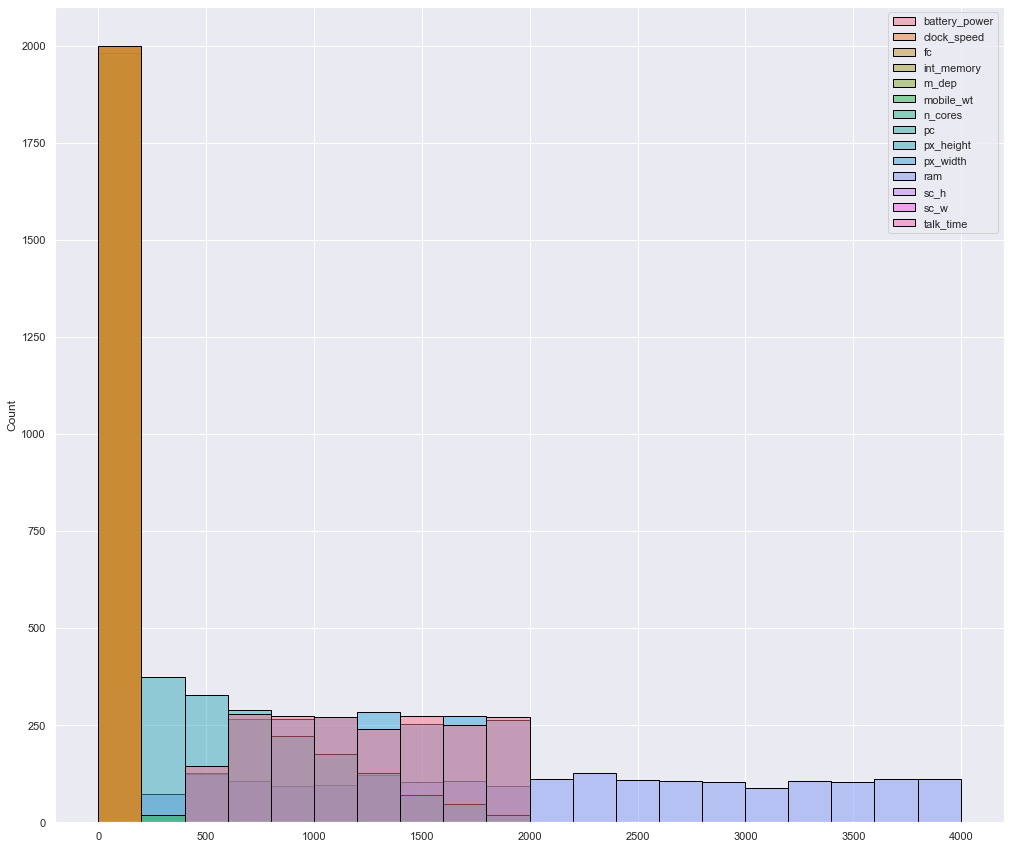

In [16]:
# Discretize continuous features
descretized_df = cl_df[cont_features]
sb.set(rc={'figure.figsize':(17,15)})
sb.histplot(data=descretized_df, bins=20, edgecolor='black')
cl_df

In [17]:
for column in descretized_df.iteritems():
    min_value = min(column[1])
    max_value = max(column[1])
    value_range = max_value - min_value
    threshold_sep_value = value_range / 3
    row_index = 0
    for value in column[1]:
        if (value >= min_value) and (value < min_value + threshold_sep_value):
            corrected_value = 1
            descretized_df.at[row_index, column[0]] = corrected_value
        elif (value >= min_value + threshold_sep_value) and (value < max_value - threshold_sep_value):
            corrected_value = 2
            descretized_df.at[row_index, column[0]] = corrected_value
        elif (value >= max_value - threshold_sep_value) and (value < max_value):
            corrected_value = 3
            descretized_df.at[row_index, column[0]] = corrected_value
        row_index += 1

nb_df = pd.DataFrame({'battery_power': descretized_df['battery_power'], 'blue': cl_df['blue'], 'clock_speed': descretized_df['clock_speed'], 'dual_sim': cl_df['dual_sim'], 'fc': descretized_df['fc'], 'four_g': cl_df['four_g'], 'int_memory': descretized_df['int_memory'], 'm_dep': descretized_df['m_dep'], 'mobile_wt': descretized_df['mobile_wt'], 'n_cores': descretized_df['n_cores'], 'pc': descretized_df['pc'], 'px_height': descretized_df['px_height'], 'px_width': descretized_df['px_width'], 'ram': descretized_df['ram'], 'sc_h': descretized_df['sc_h'], 'sc_w': descretized_df['sc_w'], 'talk_time': descretized_df['talk_time'], 'three_g': cl_df['three_g'], 'touch_screen': cl_df['touch_screen'], 'wifi': cl_df['wifi'], 'price_range': cl_df['price_range']})
nb_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1,0,3.0,0,1,0,1,2.0,3,1,...,1,1,2,1,2,3,0,0,1,1
1,2,1,1.0,1,1,1,3,3.0,2,1,...,2,3,2,3,1,1,1,1,0,2
2,1,1,1.0,1,1,1,2,3.0,2,2,...,2,3,2,2,1,2,1,1,0,2
3,1,1,3.0,0,1,0,1,3.0,2,3,...,2,3,3,3,2,2,1,0,0,2
4,3,1,1.0,0,3,1,3,2.0,2,1,...,2,2,1,1,1,3,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,1,1.0,1,1,1,1,3.0,1,3,...,2,3,1,2,1,3,1,1,0,0
1996,3,1,3.0,1,1,0,2,1.0,3,2,...,2,3,2,2,2,3,1,1,1,2
1997,3,0,1.0,1,1,1,2,3.0,1,8,...,2,3,3,1,1,1,1,1,0,3
1998,3,0,1.0,0,1,1,3,1.0,2,2,...,1,1,1,3,2,3,1,1,1,0


In [18]:
from sklearn.naive_bayes import CategoricalNB

clf = CategoricalNB()
x_train,x_test,y_train,y_test = train_test_split(nb_df[all_features], nb_df['price_range'], test_size=0.33, random_state=0)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6818181818181818

## Using a Gaussian Naive Bayes Classifier
Another alternative to the Categorical Naive Bayes classifier is the Gaussian Naive Bayes classifier. Unlike the Categorical Naive Bayes, Gaussian Naive Bayes classification algorithm utilizes a typical assumption that the continuous values associated with each target feature level are distributed according to a normal distribution.

Using the original dataset, we will construct a Gaussian Naive Bayes model (`GaussianNB` from `sklearn.naive_bayes` module). 

In [19]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
x_train,x_test,y_train,y_test = train_test_split(cl_df[all_features], cl_df['price_range'], test_size=0.33, random_state=0)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8196969696969697

The Gausian naive bayes algorithm is much more accurate. This is probably becuase the non-discretized dataframe much more closely follow a gaussian distribution than the discretized data. 